## Ce notebook sert de base et de tutoriel pour utiliser les fonctions/modules zone budget for mf6

On importe d'abord divers trucs. Les fonctions utiles pour le budget sont dans ZoneBudget_ludo et Zone_Budget_mf6 (le dernier est un prototype en programmation orientée objet)

In [1]:
import flopy as fp
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

sys.path.insert(1, '../../../../../Documents/GitHub/TM_Ludovic_Schorpp/codes_tests/modules')
# hand made functions
from ZoneBudget_ludo import *
from Zone_Budget_mf6 import *

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


Quelques fonctions pour récupérer les outputs de modflow

In [2]:
#some functions

def get_heads(model_name,workspace):
    """
    Function that returns the heads from the headfile
    model_name : str, the name of the current model
    workspace : str, the path to workspace (where output files are stored)
    obj : bool, if we want to retrieve the head object rather than the computed heads for the last stress period
    """
    headfile = '{}.hds'.format(model_name)
    fname = os.path.join(workspace,headfile)    
    hdobj = fp.utils.HeadFile(fname, precision='double') 
    head  = hdobj.get_data()
    
    return head

def get_spdis(model_name,workspace):
    """
    Function that returns the specific discharge from the cbcfile
    """
    
    spdfile = '{}.cbc'.format(model_name)
    fname = os.path.join(workspace,spdfile)    
    spdobj = fp.utils.CellBudgetFile(fname, precision='double')  
    spd  = spdobj.get_data(text="SPDIS")
    
    return spd

def get_cbc(model_name,workspace):
    cbcfile = '{}.cbc'.format(model_name)
    fname = os.path.join(workspace,cbcfile)    
    cbcobj = fp.utils.CellBudgetFile(fname, precision='double')  
    return cbcobj


model_dir sera le répertoire de travail où seront envoyé tous les fichiers de modflow 

model_name servira pour nommer les différents fichiers

exe_name est le chemin vers l'executable modflow 6

In [3]:
model_dir = "workspace"
model_name = "test_ZB"
exe_name= "../../exe/mf6.exe"

Quelques paramètres et discrétisation (plus de détails --> voir tuto sur la discrétisation)

In [4]:
res = 1
ncol = 30
nrow = 30
nlay = 3
delr = np.ones(ncol)*res
delc = np.ones(nrow)*res
top = 1
botm = [0,-1,-2]

On crée des conditions limites (charges imposées avec chd et des puits, plus de détails sur le tuto des BCs)

In [5]:
# chd
lst_chd=[]
for irow in range(nrow):
    lst_chd.append(((0,irow,0),1))

for irow in range(nrow):
    lst_chd.append(((0,irow,ncol-1),0.01))

In [6]:
wel_spd=[((2,15,15),-0.0002)]

### Le bloc suivant crée tous les packages modflows nécessaire à la simulation

In [7]:
# VERY basic modules
sim = fp.mf6.MFSimulation(sim_name='bench_ZB', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,idomain=1)

#discrétisation temporelle
tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])

#solver
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=1)

# output control (fichiers de sortie)
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),#nom du fichier budget (ne pas changer)
                            head_filerecord='{}.hds'.format(model_name),# nom du fichier des charges (ne pas changer)
                            saverecord=[('HEAD', 'LAST'), 
                                        ('BUDGET', 'LAST')],
                            printrecord=[('BUDGET', 'ALL')])

# nodeflowproperty (conductivité, flux à enregistrer, ...)
k = [1e-4,1e-6,1e-4]
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=[0,0,0], k=k,save_flows=True,save_specific_discharge=True,
                            alternative_cell_averaging="AMT-LMK")


#initialise les puits
wel = fp.mf6.ModflowGwfwel(gwf,pname="wel",maxbound=len(wel_spd),
                           stress_period_data=wel_spd,save_flows=True)

#initialise les charges imposées
chd = fp.mf6.ModflowGwfchd(gwf,pname="BCs",maxbound=len(lst_chd),
                          stress_period_data=lst_chd,save_flows=True)

In [8]:
#créer les fichiers et runer le tout
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model test_ZB...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package wel...
    writing package bcs...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
f

(True, [])

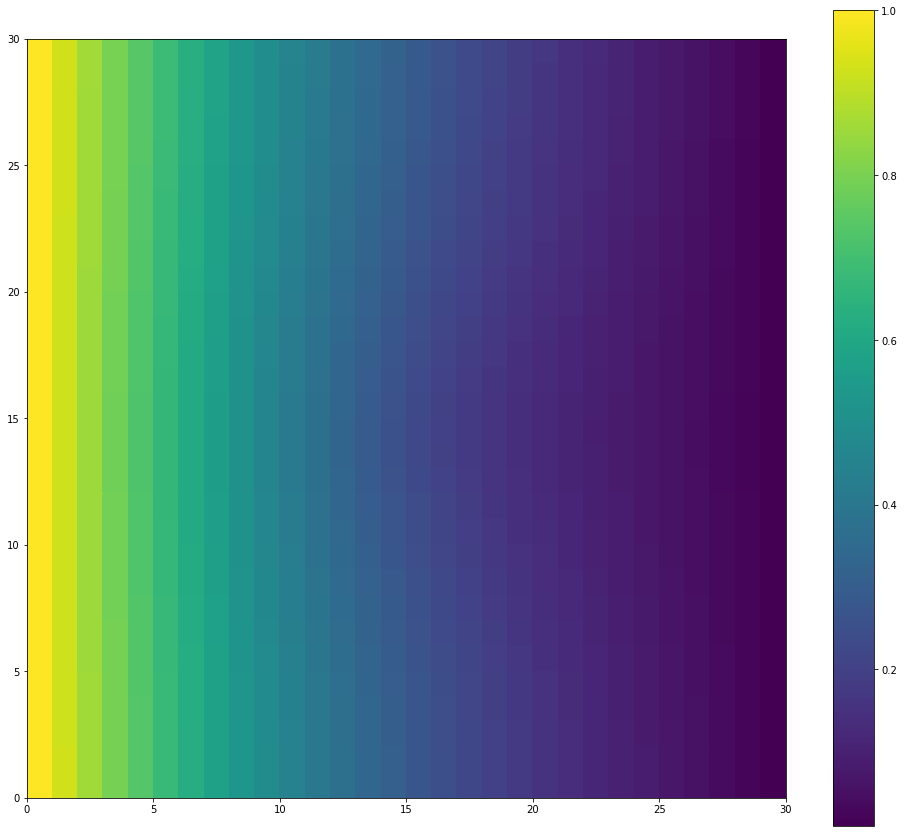

In [9]:
#récupération des données
head = get_heads(model_name,model_dir)
cbc = get_cbc(model_name,model_dir)
spdis = cbc.get_data(text='SPDIS')[-1]

fig = plt.figure(figsize=(17,15))
layer = 0
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)
hmesh=ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
plt.colorbar(hmesh)

get_Total_Budget est une fonction qui permet de récupérer les informations de budget sortis par Modflow dans le fichier .lst
Il ressort simplement un dataframe avec les in/out des différentes sources/puits pour tout le modèle

In [10]:
get_Total_Budget(model_name,model_dir)

,Pack,IN,OUT,Type
0,WEL,0.000000,0.000200,WEL
1,BCS,0.000241,0.000041,CHD


#### Petite coupe à l'aide de PlotCrossSection (plus de détails dans le tuto visualisation)

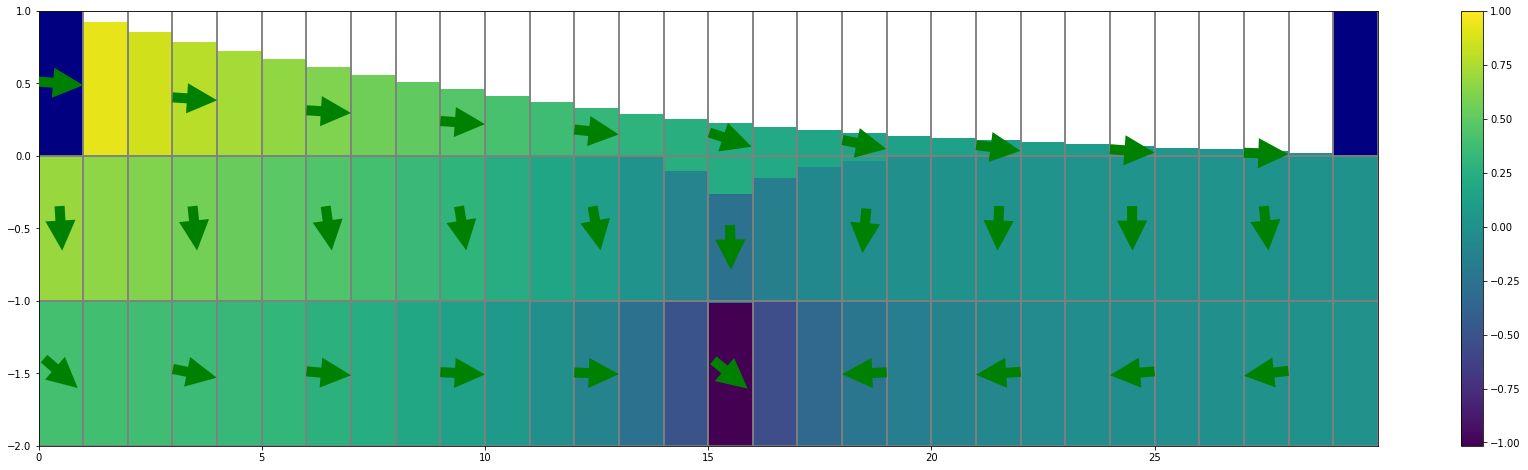

In [11]:
fig,ax = plt.subplots(figsize=(30,8))
x=fp.plot.PlotCrossSection(gwf,line={"row" :15})

arr=x.plot_array(head,masked_values=[1e30],head=head)
plt.colorbar(arr)
x.plot_ibound()
x.plot_grid()
x.plot_bc("chd")
uiver = x.plot_specific_discharge(spdis, head=head, 
                                       hstep=3, normalize=True, color='green', 
                                       scale=30, headwidth=3, headlength=3, headaxislength=3,
                                       zorder=10)

### Analyse du budget 

On va tout d'abord préparer quelques éléments nécessaires et utiliser les différentes fonctions du module.
On récupère tout d'abord les vecteurs ia et ja qui contiennent la position des différents noeuds et de leurs connexions entre eux

Puis le fichier de budget (ici cbc)

In [12]:
fname = os.path.join(model_dir, '{}.dis.grb'.format(model_name))
bgf = fp.utils.mfgrdfile.MfGrdFile(fname)
ia = bgf._datadict['IA'] - 1
ja = bgf._datadict['JA'] - 1

In [13]:
cbcfile = '{}.cbc'.format(model_name)
fname = os.path.join(model_dir,cbcfile)    
cbc = fp.utils.CellBudgetFile(fname, precision='double')  

On crée ensuite nos différentes zones. Pour cela on initialise un vecteur 3D de 0 (0 étant la valeur nulle par défaut dans mes fonctions de budgets). On va ensuite attribuer différentes valeurs aux cellules en fonction de la zone à laquelle elles appartiennent.

#### Ici la couche 1 est séparée en 2 zones (1 et 2) tandis que la couche 2 et 3 correspondent aux zones 3 et 4

In [14]:
#create the zones
zones = np.zeros([nlay,nrow,ncol])
zones[0,:,:15]=1
zones[0,:,15:]=2
zones[1]=3
zones[2]=4

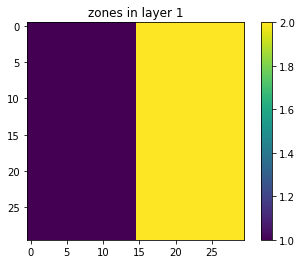

In [15]:
plt.imshow(zones[0])
plt.title("zones in layer 1")
plt.colorbar()

## Approche objet

On initie l'objet zb en tout premier lieu. Il n'a besoin que des zones et du nom du modèle/repértoire de travail
m_n est un chiffre nécessaire et qui va dépendre des paramètres d'enregistrement de flux fait précédemment. Il indique la quantité d'enregistrements de flux de pacakage qui ne sont PAS des conditions limites. En théorie m_n vaut 1 en permanent

Ci-dessous, la table des enregistrements de flux. Comme on le voit les packages conditions limites apparaissent à la ligne 2 (flow-ja-face et spdis viennent avant). Dans ce cas m_n vaudra 2 (J'ai pas trouvé mieux pour le moment désolé...)

In [16]:
pd.DataFrame(cbc.recordarray)

,kstp,kper,text,ncol,nrow,nlay,imeth,delt,pertim,totim,modelnam,paknam,modelnam2,paknam2
0,1,1,b' FLOW-JA-FACE',16740,1,-1,1,1.0,1.0,1.0,b'',b'',b'',b''
1,1,1,b' DATA-SPDIS',30,30,-3,6,1.0,1.0,1.0,b'TEST_ZB ',b'NPF ',b'TEST_ZB ',b'NPF '
2,1,1,b' WEL',30,30,-3,6,1.0,1.0,1.0,b'TEST_ZB ',b'TEST_ZB ',b'TEST_ZB ',b'WEL '
3,1,1,b' CHD',30,30,-3,6,1.0,1.0,1.0,b'TEST_ZB ',b'TEST_ZB ',b'TEST_ZB ',b'BCS '


On instancie donc zb

In [17]:
zb = Zb(zones,model_name,model_dir,cbc,m_n=2)

On peut ensuite appeler différentes méthodes en fonction de ce que l'on a besoin. Ici avec get_Budget() on peut ressortir le dataframe multi-indices budget de toutes les zones

#### Ce tableau indique la provenance/direction (FROM/TO) et la quantité (en unités du modèle) des flux pour chaque zone (2 colonnes pour chaque)

### Par exemple pour la zone 1 on a :
0.000241 $\frac{m^3}{s}$ qui proviennent des charges imposées

9e-05 $\frac{{m}^3}{s}$ qui vont à la zone 2

1.51e-04 $\frac{m^3}{s}$ qui vont à la zone 3


In [18]:
DF_Budg = zb.get_Budget()
np.round(DF_Budg,decimals=6).replace(0,"/")

zone 1           zone 2             zone 3              zone 4  \
            FROM        TO   FROM       TO      FROM        TO      FROM   
WEL            /         /      /        /         /         /         /   
BCS     0.000241         /      /  4.1e-05         /         /         /   
zone 1         /         /  9e-05        /  0.000151         /         /   
zone 2         /     9e-05      /        /     5e-05     1e-06         /   
zone 3         /  0.000151  1e-06    5e-05         /         /  0.000201   
zone 4         /         /      /        /     1e-06  0.000201         /   

                
            TO  
WEL     0.0002  
BCS          /  
zone 1       /  
zone 2       /  
zone 3   1e-06  
zone 4       /

### Il est possible de faire quelques graphes avec ces données pour que cela soit plus visuel

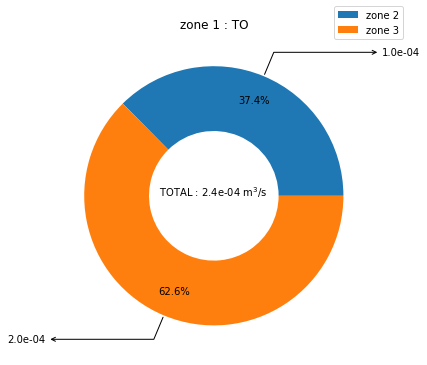

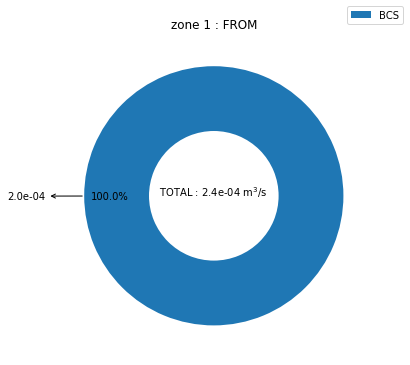

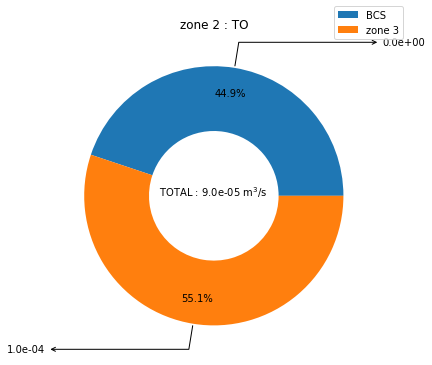

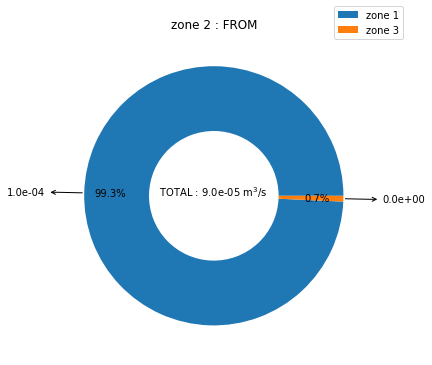

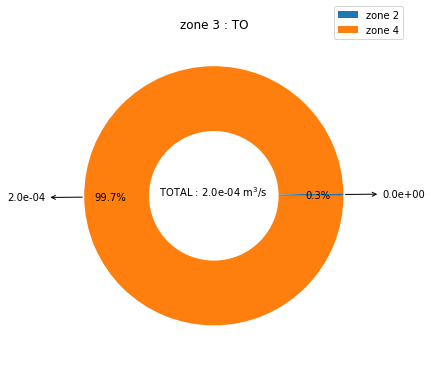

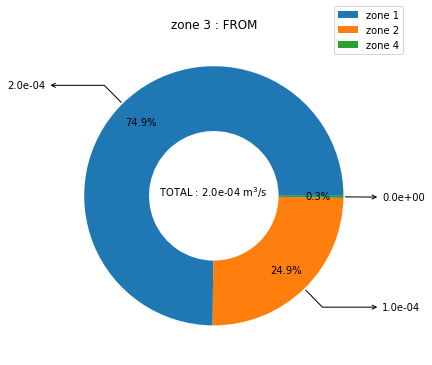

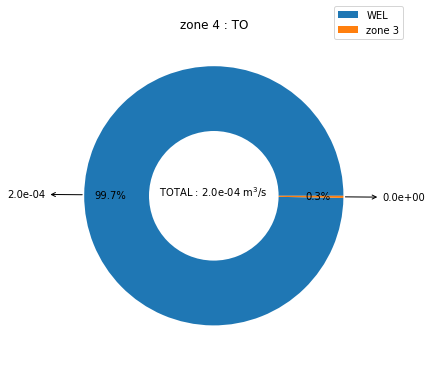

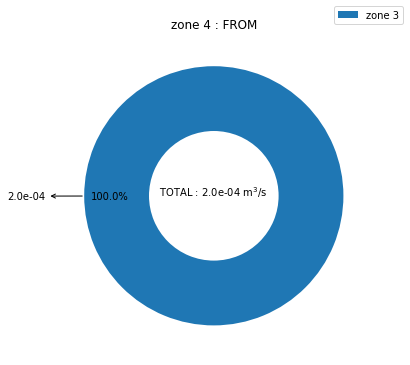

In [19]:
nzones = zb.nzones
z_list = DF_Budg.index[-nzones:]
I_O_list = ["TO","FROM"]

for z in z_list:
    for IN_OUT in I_O_list:
        fig,ax = plt.subplots(figsize=(9,9))
        labels = DF_Budg[DF_Budg[z][IN_OUT]!=0].index
        data = DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0].values
        data_pourc = DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0]/DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0].sum()
        
        wedges, texts,pct = ax.pie(data_pourc.values,pctdistance=0.8,
                                   wedgeprops=dict(width=0.5),autopct='%1.1f%%', startangle=0)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
        kw = dict(arrowprops=dict(arrowstyle="<-"),
                  bbox=bbox_props, zorder=0, va="center")
        xt = -5
        yt = -5
        ### arrows
        for i, p in enumerate(wedges):
            xta = xt
            yta = yt
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            if ang == 180:
                ang += 0.1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            xt = 1.3*np.sign(x)
            yt = 1.2*y
            if xt != xt:
                while((yta-yt)**2)< 0.01:
                    if yt >= yta:
                        yt += 0.01
                    else:
                        yt -= 0.01
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            annote =  "%.1e"%np.round(data[i],4)
            ax.annotate(annote, xy=(x, y), xytext=(xt,yt),
                        horizontalalignment=horizontalalignment, **kw)
        ###

        ax.set_title("{} : {}".format(z,IN_OUT))
        ax.set_position([0.1,0.1,0.5,0.7])
        ax.legend(wedges,labels,bbox_to_anchor=(1.1, 1.1))
        ax.text(-0.42,0,"TOTAL : {} m$^3/$s".format("%.1e"%np.round(data.sum(),5)))
        #fig.savefig('pictures/{}_{}.png'.format(z,IN_OUT))
        plt.show()

zones_plot permet de faire un plot de toutes les couches et des zones qui y sont associées

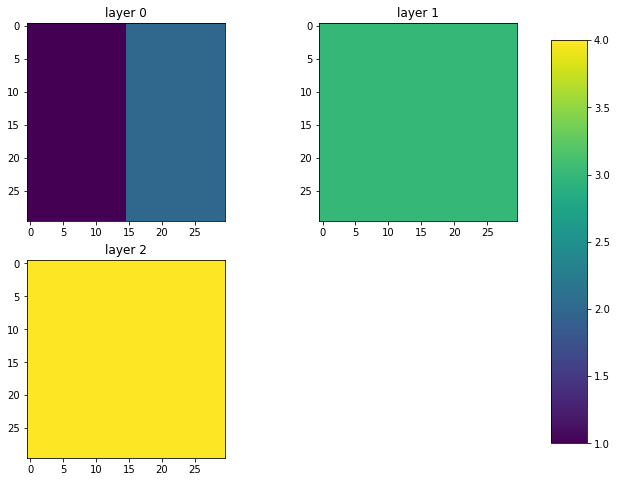

In [20]:
zb.zones_plot()

### Z2Z_3D est une méthode qui retourne un 3D array (nlay,nrow,ncol) avec les flux entre 2 zones

#### syntax : self.Z2Z_3D(zone1,zone2,kstpkper=None)
zone1 et zone2 sont les numéros des zones d'intérêt pour lesquels on veut voir les flux

kstpkper est un tuple indiquant la stress period et le time step d'intérêt

Text(0.5, 1.0, 'flux from z1 to z3')

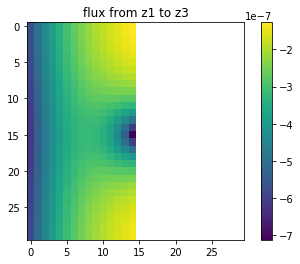

In [21]:
a=plt.imshow(zb.Z2Z_3D(1,3)[0])
plt.colorbar()
#a.set_clim(-9.5e-7,0.4e-7)
plt.title("flux from z1 to z3")

Text(0.5, 1.0, 'flux from z2 to z3')

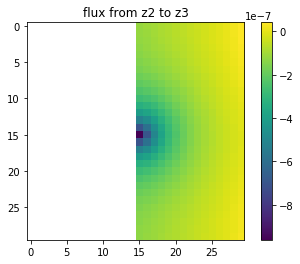

In [22]:
plt.imshow(zb.Z2Z_3D(2,3)[0])
plt.colorbar()
plt.title("flux from z2 to z3")